In [17]:
"""
graph_SCModal_testing.py

Test out the updated SCModal framework to account for spatial modality
on the full Xeminum dataset.

Outputs:
 - 
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import umap
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import random

In [18]:
# ---------------------------
# Data loading & preprocessing
# ---------------------------
def load_and_preprocess(ref_path="SmallData/xenium_reference_common_genes.h5ad",
                        spat_path="SmallData/xenium_spatial_common_genes.h5ad"):
    # load
    B = sc.read_h5ad(ref_path)
    A = sc.read_h5ad(spat_path)

    # Prefer obs column with broad labels (user should have created 'broad_cell_type' earlier)
    possible_ref_cols = ["broad_cell_type", "celltype_major", "celltype", "cell_type"]
    ref_label_col = next((c for c in possible_ref_cols if c in B.obs.columns), None)
    possible_spat_cols = ["broad_cell_type", "cell_type", "predicted_label"]
    spat_label_col = next((c for c in possible_spat_cols if c in A.obs.columns), None)

    if ref_label_col is None:
        raise RuntimeError("Reference label column not found. Set 'broad_cell_type' or similar in B.obs.")
    if spat_label_col is None:
        print("Warning: spatial label column not found. Spatial labels will be None (can't compute test acc).")

    # Normalize total and log1p (inplace on copies)
    Bc = B.copy()
    Ac = A.copy()
    sc.pp.normalize_total(Bc, target_sum=1e4)
    sc.pp.log1p(Bc)
    sc.pp.normalize_total(Ac, target_sum=1e4)
    sc.pp.log1p(Ac)

    # Convert to dense arrays (small 2k dataset assumed)
    X_ref = Bc.X.toarray() if hasattr(Bc.X, "toarray") else Bc.X
    X_spat = Ac.X.toarray() if hasattr(Ac.X, "toarray") else Ac.X

    # labels
    y_ref = Bc.obs[ref_label_col].astype(str).values
    y_spat = Ac.obs[spat_label_col].astype(str).values if spat_label_col in Ac.obs.columns else None

    # map labels to ints
    all_labels = np.unique(np.concatenate([y_ref] + ([y_spat] if y_spat is not None else [])))
    label_to_id = {lab: i for i, lab in enumerate(all_labels)}
    y_ref_id = np.array([label_to_id[l] for l in y_ref])
    y_spat_id = np.array([label_to_id[l] for l in y_spat]) if y_spat is not None else None

    # spatial coords
    if "spatial" not in Ac.obsm_keys():
        raise RuntimeError("Spatial coords key 'spatial' not found in A.obsm.")
    coords = Ac.obsm["spatial"]

    return (X_ref.astype(np.float32), y_ref_id, Bc.obs_names.values, label_to_id,
            X_spat.astype(np.float32), y_spat_id, Ac.obs_names.values, coords, all_labels)


In [19]:
X_ref, y_ref, ref_ids, label_to_id, X_spat, y_spat, spat_ids, coords, all_labels = load_and_preprocess(
         ref_path="SmallData/xenium_reference_common_genes.h5ad",
         spat_path="SmallData/xenium_spatial_common_genes.h5ad"
)

print('Loaded datasets:')
print('X_ref shape:', getattr(X_ref, 'shape', None))
print('X_spat shape:', getattr(X_spat, 'shape', None))
print('coords shape:', getattr(coords, 'shape', None))

Loaded datasets:
X_ref shape: (2000, 308)
X_spat shape: (2000, 308)
coords shape: (2000, 2)


/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


In [20]:
from scmodal.model import Model

In [21]:
m = Model(batch_size=64, training_steps=20000, n_latent=16, n_KNN=10,
          lambdaAE=12.0, lambdaLA=12.0, lambdaMNN=0.8, lambdaGeo=8.0, lambdaGAN=.5)
print('Model created. Running preprocess...')

Model created. Running preprocess...


In [22]:
adata_ref = sc.read_h5ad('SmallData/xenium_reference_common_genes.h5ad')
adata_spat = sc.read_h5ad('SmallData/xenium_spatial_common_genes.h5ad')
print('AnnData shapes:', adata_ref.shape, adata_spat.shape)

AnnData shapes: (2000, 308) (2000, 308)


In [23]:
m.preprocess(adata_spat, adata_ref, shared_gene_num=308)
print('Preprocess completed in Model.')
print('emb_A shape:', getattr(m, 'emb_A', None).shape)
print('coords_A shape:', getattr(m, 'coords_A', None).shape)
print('emb_B shape:', getattr(m, 'emb_B', None).shape)
print('coords_B shape:', getattr(m, 'coords_B', None))

Preprocessing complete.
A: (2000, 308), coords: (2000, 2)
B: (2000, 308), coords: None
Preprocess completed in Model.
emb_A shape: (2000, 308)
coords_A shape: (2000, 2)
emb_B shape: (2000, 308)
coords_B shape: None


In [24]:
m.train()

Begining time:  Thu Nov 27 21:47:54 2025
step 0, loss_D=0.005665, loss_GAN=-0.005445, loss_AE=5559257.000000, loss_Geo=-11.496536, loss_LA=80531576.000000, loss_MNN=1186374.750000
step 2000, loss_D=0.004304, loss_GAN=-0.004052, loss_AE=47.304779, loss_Geo=-12.072972, loss_LA=13.226721, loss_MNN=127.004936
step 4000, loss_D=0.005755, loss_GAN=-0.004797, loss_AE=37.998302, loss_Geo=-13.378136, loss_LA=11.892476, loss_MNN=8.046167
step 6000, loss_D=0.053488, loss_GAN=-0.051190, loss_AE=28.119972, loss_Geo=-14.021035, loss_LA=13.344986, loss_MNN=3.568102
step 8000, loss_D=0.801208, loss_GAN=-0.772154, loss_AE=22.188507, loss_Geo=-14.344357, loss_LA=0.158743, loss_MNN=1.422067
step 10000, loss_D=0.779541, loss_GAN=-0.773803, loss_AE=21.713100, loss_Geo=-14.409184, loss_LA=0.167595, loss_MNN=1.435512
step 12000, loss_D=0.835991, loss_GAN=-0.819530, loss_AE=21.747990, loss_Geo=-14.588768, loss_LA=0.081872, loss_MNN=1.191074
step 14000, loss_D=0.766111, loss_GAN=-0.758636, loss_AE=14.231652, l

In [25]:
m.eval()

Begining time:  Thu Nov 27 22:08:29 2025
Ending time:  Thu Nov 27 22:08:29 2025
Evaluating takes 0.20 seconds


/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


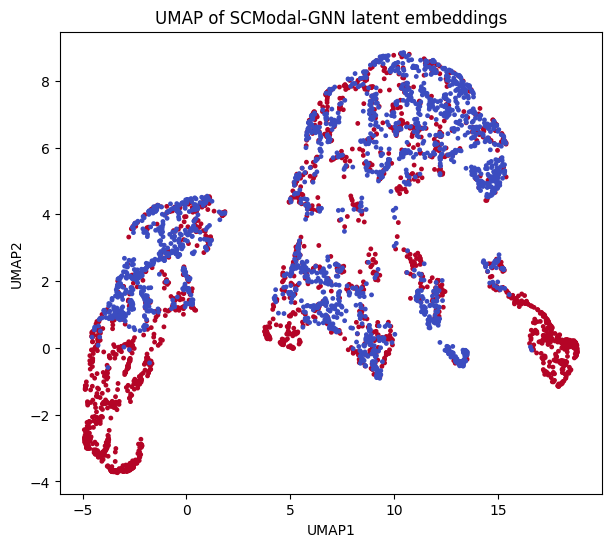

In [26]:
import numpy as np
import umap
import matplotlib.pyplot as plt

# m.latent is an (NA + NB) × latent_dim array
Z = m.latent

# Build UMAP
um = umap.UMAP(n_neighbors=20, min_dist=0.1, metric="euclidean", random_state=42)
Z_umap = um.fit_transform(Z)

# Colors: dataset label
labels = np.array(
    ["A"] * m.emb_A.shape[0] + 
    ["B"] * m.emb_B.shape[0]
)

plt.figure(figsize=(7,6))
plt.scatter(Z_umap[:,0], Z_umap[:,1], c=(labels=="A"), cmap="coolwarm", s=6)
plt.title("UMAP of SCModal-GNN latent embeddings")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()


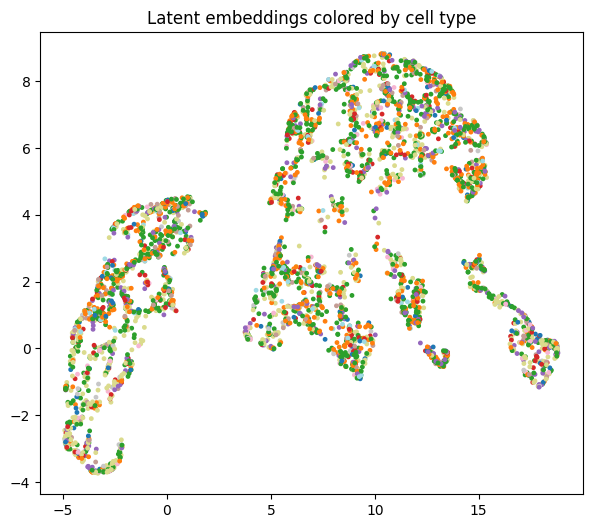

In [27]:
cell_labels = np.concatenate([y_ref, y_spat])

plt.figure(figsize=(7,6))
plt.scatter(Z_umap[:,0], Z_umap[:,1], c=cell_labels, s=6, cmap="tab20")
plt.title("Latent embeddings colored by cell type")
plt.show()


In [28]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(Z, cell_labels)
print("Silhouette Score:", sil_score)


Silhouette Score: -0.16869211196899414


In [29]:
import numpy as np

unique_labels = np.unique(cell_labels)
for lab in unique_labels:
    idx = np.where(cell_labels == lab)[0]
    Z_lab = Z[idx]
    # Pairwise distance to centroid
    centroid = Z_lab.mean(axis=0)
    mean_dist = np.mean(np.linalg.norm(Z_lab - centroid, axis=1))
    print(f"{lab}: mean distance = {mean_dist:.4f}")


0: mean distance = 3.8683
1: mean distance = 3.1471
2: mean distance = 3.4650
3: mean distance = 3.8494
4: mean distance = 3.8842
5: mean distance = 3.7662
6: mean distance = 4.7345
7: mean distance = 5.2461
8: mean distance = 4.5591
9: mean distance = 2.7146


In [30]:
import os
## Store the embeddings
save_dir = "SCModal_embeddings"
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "latent.npy"), m.latent)
np.save(os.path.join(save_dir, "data_Aspace.npy"), m.data_Aspace)
np.save(os.path.join(save_dir, "data_Bspace.npy"), m.data_Bspace)

print("Saved: latent.npy, data_Aspace.npy, data_Bspace.npy")

Saved: latent.npy, data_Aspace.npy, data_Bspace.npy
